In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import os
import glob
import geopandas as gpd
import folium
import re

In [3]:
BASE_DIR = os.getcwd()

def build_path(*parts):
    return os.path.join(BASE_DIR, *parts)

FIELD_CONTACT_DIR = os.path.join('..', '..', 'data', 'fieldcontact')
POLICE_REQUESTS_DIR = os.path.join('..', '..', 'data', 'policerequests')
OT_EVENTS_DIR = os.path.join('..', '..', 'data', 'otevents')

# --- 📂 Load Data ---
otevents = pd.read_csv(os.path.join(OT_EVENTS_DIR, '2019_otevents.csv'))
fc_files = glob.glob(os.path.join(FIELD_CONTACT_DIR, '*.csv'))
field_contacts = pd.concat([pd.read_csv(f) for f in fc_files], ignore_index=True)
police_requests = pd.read_csv(os.path.join(POLICE_REQUESTS_DIR, 'Police_Record_Request_Apr_1_Jun_30_2021.csv'))
# 1. Find all court overtime files
court_files = glob.glob(build_path(OT_EVENTS_DIR, '*_courtot.csv'))

# 2. Read all files into a list of DataFrames
court_dfs = [pd.read_csv(f) for f in court_files]

# 3. Concatenate all into one big DataFrame
courttot = pd.concat(court_dfs, ignore_index=True)

court_dfs = []

for f in court_files:
    df = pd.read_csv(f)
    year = int(f.split('/')[-1].split('_')[0])  # extract year from filename
    df['year'] = year
    court_dfs.append(df)

courttot = pd.concat(court_dfs, ignore_index=True)

print(courttot[['OTDATE', 'year']].head())

      OTDATE  year
0  02-Jan-20  2020
1  03-Jan-20  2020
2  03-Jan-20  2020
3  03-Jan-20  2020
4  03-Jan-20  2020


In [4]:
# Overtime Events Preprocessing
def preprocess_otevents(df):
    df['OTDATE'] = pd.to_datetime(df['OTDATE'], errors='coerce')
    df['OTHOURS'] = df['OTHOURS'].fillna(0)
    df['day_of_week_num'] = df['OTDATE'].dt.dayofweek
    df['start_hour'] = df['STARTTIME'].apply(lambda x: int(str(x).zfill(4)[:2]) if pd.notnull(x) else np.nan)
    df['assigned_code'] = LabelEncoder().fit_transform(df['ASSIGNED_DESC'].astype(str))
    return df

otevents = preprocess_otevents(otevents)

# Field Contacts Preprocessing
def preprocess_field_contacts(df):
    df['contact_date'] = pd.to_datetime(df['contact_date'], errors='coerce')
    df['high_risk'] = df['key_situations'].fillna('').apply(lambda x: any(word in x for word in ['Gun', 'Drugs', 'Gang', 'Shots Fired']))
    df['stop_duration'] = df['stop_duration'].fillna(df['stop_duration'].median())
    df['basis'] = df['basis'].fillna('Unknown')
    return df

field_contacts = preprocess_field_contacts(field_contacts)

# Police Requests Preprocessing
def preprocess_police_requests(df):
    df['OTDATE'] = pd.to_datetime(df['OTDATE'], errors='coerce')
    df['is_civilian'] = df['RANK'].apply(lambda x: x == 'Civili')
    df['DESCRIPTION'] = df['DESCRIPTION'].astype(str)
    df['is_covid'] = df['DESCRIPTION'].str.contains('COVID', na=False)
    df['start_hour'] = df['STARTTIME'].apply(lambda x: int(str(x).zfill(4)[:2]) if pd.notnull(x) else np.nan)
    return df

police_requests = preprocess_police_requests(police_requests)

/var/folders/_r/zj6d9vt949dd8s48h6_3_45m0000gn/T/ipykernel_62567/3620838110.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['OTDATE'] = pd.to_datetime(df['OTDATE'], errors='coerce')


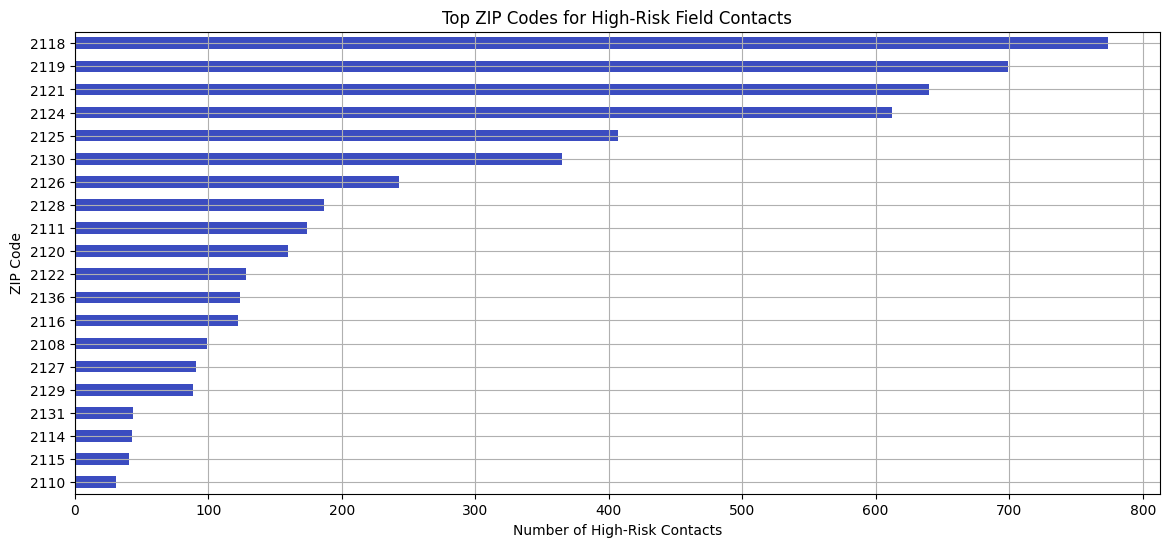

In [5]:
high_risk_zip_counts = field_contacts[field_contacts['high_risk'] == True]['zip'].value_counts()

plt.figure(figsize=(14,6))
high_risk_zip_counts.head(20).sort_values(ascending=True).plot(kind='barh', cmap='coolwarm')
plt.title('Top ZIP Codes for High-Risk Field Contacts')
plt.xlabel('Number of High-Risk Contacts')
plt.ylabel('ZIP Code')
plt.grid(True)
plt.show()


In [6]:
# Build the correct full path to the .shp file
zip_shape_path = build_path(FIELD_CONTACT_DIR, 'zip_codes', 'ZIP_Codes.shp')

# Load the shapefile (GeoPandas automatically finds .shx, .dbf, etc if they're in the same folder)
zip_shapes = gpd.read_file(zip_shape_path)

# Quick check: see what columns are available
print(zip_shapes.columns)
zip_shapes.head()


Index(['ZIP5', 'Shape_Leng', 'Shape_Area', 'shape_wkt', 'geometry'], dtype='object')


ZIP5  Shape_Leng  Shape_Area shape_wkt  \
0  02134    0.133144    0.000378      None   
1  02125    0.198983    0.000657      None   
2  02110    0.059920    0.000067      None   
3  02118    0.103276    0.000316      None   
4  02126    0.149134    0.000616      None   

                                            geometry  
0  POLYGON ((-71.12340 42.36420, -71.12332 42.363...  
1  POLYGON ((-71.04541 42.32380, -71.04472 42.323...  
2  POLYGON ((-71.05109 42.36418, -71.04960 42.364...  
3  POLYGON ((-71.06315 42.34688, -71.06304 42.346...  
4  POLYGON ((-71.09670 42.29094, -71.09641 42.290...

<Figure size 1400x1000 with 0 Axes>

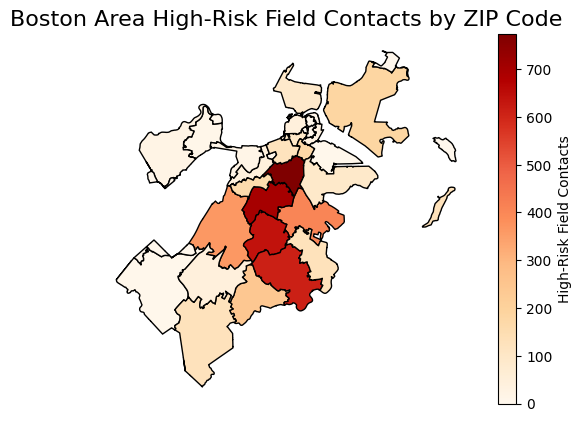

In [7]:
# High-risk field contacts
high_risk_zip_counts = field_contacts[field_contacts['high_risk'] == True]['zip'].value_counts().reset_index()
high_risk_zip_counts.columns = ['ZIP5', 'high_risk_count']

# Fix ZIPs: pad with zeros to 5 digits
high_risk_zip_counts['ZIP5'] = high_risk_zip_counts['ZIP5'].apply(lambda x: str(x).zfill(5))
zip_shapes['ZIP5'] = zip_shapes['ZIP5'].apply(lambda x: str(x).zfill(5))

# Merge
merged = zip_shapes.merge(high_risk_zip_counts, on='ZIP5', how='left')
merged['high_risk_count'] = merged['high_risk_count'].fillna(0)

# Plot
plt.figure(figsize=(14,10))
merged.plot(
    column='high_risk_count', 
    cmap='OrRd', 
    edgecolor='black', 
    legend=True,
    legend_kwds={'label': "High-Risk Field Contacts", 'orientation': "vertical"},
    missing_kwds={"color": "lightgrey", "label": "No Data"}
)
plt.title('Boston Area High-Risk Field Contacts by ZIP Code', fontsize=16)
plt.axis('off')
plt.show()

In [8]:
# Build correct path
police_districts_path = build_path(FIELD_CONTACT_DIR, 'police_districts', 'Police_Districts.shp')

# Load the police districts shapefile
district_shapes = gpd.read_file(police_districts_path)

# Preview only DISTRICT and ID columns
print(district_shapes[['DISTRICT', 'ID']].head(30))


   DISTRICT   ID
0       A15  A15
1        A7   A7
2        A1   A1
3        C6   C6
4        D4   D4
5       D14  D14
6       E13  E13
7        E5   E5
8        B3   B3
9       C11  C11
10      E18  E18
11       B2   B2


In [9]:
allowed_districts = ['A1', 'A7', 'A15', 'B2', 'B3', 'C6', 'C11', 'D4', 'D14', 'E5', 'E13', 'E18']

# --- Step 1: Filter out only valid district-related rows (contain district-like pattern) ---

# Only keep rows where ASSIGNED_DESC contains "-" (like "C-6") or "DISTRICT" (like "DISTRICT 02")
valid_court = courttot[courttot['ASSIGNED_DESC'].str.contains(r'DISTRICT|\-', regex=True, na=False)].copy()

# --- Step 2: Standardize the format ---

# Clean spaces
valid_court['ASSIGNED_DESC'] = valid_court['ASSIGNED_DESC'].str.strip()

# Remove "DCU SQUAD", "DETECTIVES", etc
valid_court['DISTRICT_CLEAN'] = valid_court['ASSIGNED_DESC'].str.replace(r'DCU SQUAD|DETECTIVES|', '', regex=True)

# Remove extra spaces
valid_court['DISTRICT_CLEAN'] = valid_court['DISTRICT_CLEAN'].str.strip()

# Remove hyphens like "C-6" → "C6", "E-13" → "E13"
valid_court['DISTRICT_CLEAN'] = valid_court['DISTRICT_CLEAN'].str.replace('-', '')

# Remove "DISTRICT " prefix if it exists
valid_court['DISTRICT_CLEAN'] = valid_court['DISTRICT_CLEAN'].str.replace('DISTRICT ', '')

# Final strip to be safe
valid_court['DISTRICT_CLEAN'] = valid_court['DISTRICT_CLEAN'].str.strip()

# --- Step 3: Print to verify ---
print(valid_court[['ASSIGNED_DESC', 'DISTRICT_CLEAN']].head(10))


       ASSIGNED_DESC DISTRICT_CLEAN
0   C-6   DETECTIVES             C6
1        DISTRICT 02             02
2        DISTRICT 02             02
3        DISTRICT 02             02
4   B-3   DETECTIVES             B3
5    C-11 DETECTIVES            C11
6    C-11 DETECTIVES            C11
7    C-11 DETECTIVES            C11
9        DISTRICT 04             04
12  D-4   DETECTIVES             D4


In [10]:
district_mapping = {
    '01': 'A1',
    '02': 'A15',
    '03': 'B2',
    '04': 'D4',
    '05': 'E5',
    '06': 'C6',
    '07': 'A7',
    '11': 'C11',
    '13': 'E13',
    '14': 'D14',
    '18': 'E18'
}

# Fix any that are just numbers
valid_court['DISTRICT_FINAL'] = valid_court['DISTRICT_CLEAN'].replace(district_mapping)

# If it's already letters like "C6", "B3", it stays
valid_court['DISTRICT_FINAL'] = valid_court['DISTRICT_FINAL'].fillna(valid_court['DISTRICT_CLEAN'])

# Only keep rows where DISTRICT_FINAL is in allowed list
valid_court = valid_court[valid_court['DISTRICT_FINAL'].isin(allowed_districts)]



In [11]:
def extract_district(assigned_desc):
    if pd.isnull(assigned_desc):
        return None
    match = re.search(r'([A-E]\-?\d{1,2})', assigned_desc)
    if match:
        return match.group(1).replace('-', '')
    match = re.search(r'DISTRICT (\d{1,2})', assigned_desc)
    if match:
        return 'D' + match.group(1)
    return None

courttot['DISTRICT_FINAL'] = courttot['ASSIGNED_DESC'].apply(extract_district)

# Filter out rows with no matched district
courttot = courttot[courttot['DISTRICT_FINAL'].notna()]

In [12]:
# Group total overtime per district
court_hours_by_district = courttot.groupby('DISTRICT_FINAL')['OTHOURS'].sum().reset_index()
court_hours_by_district.columns = ['DISTRICT', 'court_othours']  # rename to match shapefile

In [13]:
# Merge on DISTRICT (NOT DISTRICT_CLEAN anymore!)
district_shapes = district_shapes.merge(court_hours_by_district, on='DISTRICT', how='left')

# Fill missing with 0 if any district has no OT hours
district_shapes['court_othours'] = district_shapes['court_othours'].fillna(0)


In [14]:
# --- Base Map ---
m = folium.Map(location=[42.3601, -71.0589], zoom_start=11)

# --- High-Risk Field Contacts ---
folium.Choropleth(
    geo_data=merged,
    data=merged,
    columns=['ZIP5', 'high_risk_count'],
    key_on='feature.properties.ZIP5',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='High-Risk Field Contacts',
    name='High-Risk Field Contacts'
).add_to(m)

folium.GeoJson(
    merged,
    name='ZIP5 Hover',
    tooltip=folium.features.GeoJsonTooltip(
        fields=['ZIP5', 'high_risk_count'],
        aliases=['ZIP Code:', 'High-Risk Contacts:'],
        localize=True
    )
).add_to(m)

# --- Court Overtime ---
folium.Choropleth(
    geo_data=district_shapes,
    data=district_shapes,
    columns=['DISTRICT', 'court_othours'],
    key_on='feature.properties.DISTRICT',
    fill_color='Blues',
    fill_opacity=0.6,
    line_opacity=0.4,
    legend_name='Court Overtime Hours',
    name='Court Overtime (Districts)'
).add_to(m)

folium.GeoJson(
    district_shapes,
    name='District Hover',
    tooltip=folium.features.GeoJsonTooltip(
        fields=['DISTRICT', 'court_othours'],
        aliases=['District:', 'Court OT Hours:'],
        localize=True)
).add_to(m)

# --- Layer Control ---
folium.LayerControl(collapsed=False).add_to(m)

# Show Map
m


In [15]:
figures_path = build_path('figures')
os.makedirs(figures_path, exist_ok=True)

# Save the final map
m.save(os.path.join(figures_path, 'final_map.html'))

print("Map saved to figures/final_map.html!")

Map saved to figures/final_map.html!
